# Lab Exercise 1: Advanced Python with Pandas and Numpy

## Importing python modules

In [2]:
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
import matplotlib.pyplot as plt
import db_config 

## Data Loading

In [4]:
# Load each CSV file into a separate DataFrame
orders_df = pd.read_csv('ShopEase Data/orders.csv')  
products_df = pd.read_csv('ShopEase Data/products.csv')  

## Display top rows of:


1. Order data
2. Product data




In [6]:
# Display the first few rows of each DataFrame
print("\nOrders Data:")
print(orders_df.head())
print("\nProducts Data:")
print(products_df.head())



Orders Data:
   order_id  Cutomer_id order_date  product_id  quantity
0         1          20  11/1/2024           3         2
1         2          36  11/1/2024           1         1
2         3           1  11/1/2024           8         3
3         4          36  11/2/2024           6         1
4         5          14  11/2/2024          12         2

Products Data:
   product_id    product_name     category   price
0           1          Laptop  Electronics  1200.0
1           2      Smartphone  Electronics   800.0
2           3          Tablet  Electronics   450.0
3           4  Wireless Mouse  Electronics    25.0
4           5        Keyboard  Electronics    50.0


In [8]:
# Checking column names in each DataFrame
print(orders_df.columns)
print(products_df.columns)

Index(['order_id', 'Cutomer_id', 'order_date', 'product_id', 'quantity'], dtype='object')
Index(['product_id', 'product_name', 'category', 'price'], dtype='object')


## Merging orders with products to form the sales data frame

In [10]:
# merging the orders_df with products_df on product_id
sales_df = pd.merge(orders_df, products_df, on = 'product_id')

In [12]:
sales_df.head()

,order_id,Cutomer_id,order_date,product_id,quantity,product_name,category,price
0,1,20,11/1/2024,3,2,Tablet,Electronics,450.0
1,2,36,11/1/2024,1,1,Laptop,Electronics,1200.0
2,3,1,11/1/2024,8,3,Headphones,Electronics,150.0
3,4,36,11/2/2024,6,1,Smartwatch,Electronics,200.0
4,5,14,11/2/2024,12,2,Desk,Furniture,300.0


## Cleaning sales dataframes

In [14]:
# Replace missing values with 0
sales_df.fillna(0, inplace=True) 

# remove rows with missing values
sales_df.dropna(inplace=True)

# remove duplicate rows if any
sales_df.drop_duplicates(inplace=True)

#converting columns to the correct data types
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])
sales_df['quantity'] = sales_df['quantity'].astype(int)
sales_df['price'] = sales_df['price'].astype(float)



## Total Revenue per order with Numpy

In [16]:
# creating a new column 'total_revenue' by multiplying quantity and price columns
sales_df['total_revenue'] = sales_df['quantity'] * sales_df['price']


## Data Transformation

In [18]:
# Extract Year, Month, and Day from the Date Column
sales_df['year'] = sales_df['order_date'].dt.year
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['day'] = sales_df['order_date'].dt.day


## Visualization (Monthly Sales Trend)

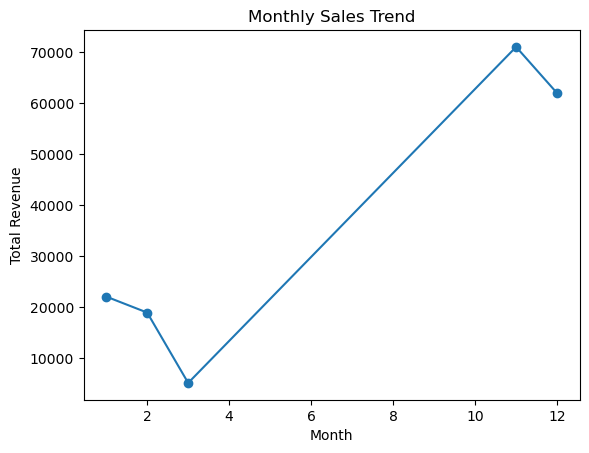

In [20]:
monthly_sales = sales_df.groupby('month')['total_revenue'].sum()
monthly_sales.plot(kind='line', marker='o', title="Monthly Sales Trend")
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()


## Database connection and populating

In [40]:
try:
    # Setting up connection details
    connection = mysql.connector.connect(
        host=db_config.host,
        user=db_config.user,
        password=db_config.password,
        database=db_config.database
    )
    
    if connection.is_connected():
        print("Connection to the database was successful.")
        cursor = connection.cursor()

        # Creating the database schema
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS sales_data (
            order_id INT PRIMARY KEY,
            order_date DATE,
            quantity INT,
            price FLOAT,
            total_revenue FLOAT,
            year INT,
            month INT,
            day INT
        );
        """)
        connection.commit()  # Commit the transaction
        print("Table created successfully.")
        for _, row in sales_df.iterrows():
            cursor.execute("""
            INSERT INTO sales_data (order_id, order_date, quantity, price, total_revenue, year, month, day)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """, (row['order_id'], row['order_date'], row['quantity'], row['price'], row['total_revenue'],
                  row['year'], row['month'], row['day']))
            connection.commit()
        

        # verify data in database
        cursor.execute("SELECT * FROM sales_data LIMIT 5")
        rows = cursor.fetchall()
        for row in rows:
            print(row)

except Error as e:
    print(f"Error connecting to MySQL: {e}")
    print(db_config.password)

finally:
    # Close the connection if it was established
    if 'connection' in locals() and connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed.")




Connection to the database was successful.
Table created successfully.
(1, datetime.date(2024, 11, 1), 2, 450.0, 900.0, 2024, 11, 1)
(2, datetime.date(2024, 11, 1), 1, 1200.0, 1200.0, 2024, 11, 1)
(3, datetime.date(2024, 11, 1), 3, 150.0, 450.0, 2024, 11, 1)
(4, datetime.date(2024, 11, 2), 1, 200.0, 200.0, 2024, 11, 2)
(5, datetime.date(2024, 11, 2), 2, 300.0, 600.0, 2024, 11, 2)
MySQL connection is closed.
